In [28]:
import sys
import os

current_directory = os.getcwd()        
parent_directory = os.path.dirname(current_directory)
sys.path.append(parent_directory)

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from tensorflow import keras
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from spektral.layers import GCNConv

from postprocess.threshold import flood_threshold, drought_threshold
from preprocess.BaselinePrerocess import baseline_process, baseline_process_for_gate_predictor
from preprocess.GraphTransformerPrerocess import graph_water_transformer_cov_process_for_gate_predictor
from preprocess.graph import graph_topology_5

import pygad
import time

In [30]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

### Preprocess

In [31]:
# ====== preprocessing parameters ======
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9
sigma2 = 0.1
epsilon = 0.5

In [34]:
train_X_mask, val_X_mask, test_X_mask, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler = baseline_process(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')


In [35]:
train_cov, val_cov, test_cov, \
train_tws_reshape, val_tws_reshape, test_tws_reshape, \
train_gate_pump_y, val_gate_pump_y, test_gate_pump_y, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler, gate_scalar = graph_water_transformer_cov_process_for_gate_predictor(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')
train_tws/val_tws/test_tws: (77069, 5, 72) (9634, 5, 72) (19268, 5, 72) 
 train_cov/val_cov/test_cov: (77069, 96, 12) (9634, 96, 12) (19268, 96, 12) 
 train_ws_y/val_ws_y/test_ws_y: (77069, 96) (9634, 96) (19268, 96) 
  train_gate_pump_y/val_gate_pump_y/test_gate_pump_y: (77069, 24, 7) (9634, 24, 7) (19268, 24, 7)


In [36]:
train_adj_mat, val_adj_mat, test_adj_mat = graph_topology_5(n_hours, K, sigma2, epsilon, len(train_ws_y), len(val_ws_y), len(test_ws_y))

node_indices: [0 0 0 0 1 1 2 2 3 3 4 4] 
neighbor_indices: [1 2 3 4 0 2 0 1 0 4 0 3]
number of nodes: 5, number of edges: 12


### Select event

In [106]:
start_idx = 18000
end_idx = 18100-45
duration = end_idx - start_idx

In [107]:
ws1 = test_ws_y[start_idx:end_idx, :]
ws1 = ws_scaler.inverse_transform(ws1)
ws1.shape

(55, 96)

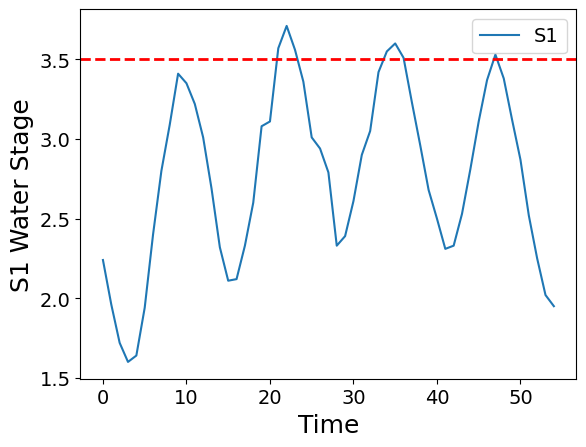

In [108]:
plt.plot(ws1[:, 0], label='S1')
plt.axhline(y = 3.5, color='r', linestyle='dashed', linewidth=2)
plt.xlabel('Time', fontsize=18)
plt.ylabel('S1 Water Stage', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

### Get optimizable and not optimizable variables

In [109]:
# X = test_X_mask[start_idx:end_idx, :, :]
# X_1d = np.reshape(X, -1)

# print(X.shape)
# print(X_1d.shape)

In [110]:
# optimizable
gate_state = test_cov[start_idx:end_idx, :, 2:9]
gate_state_1d = np.reshape(gate_state, -1)

print(gate_state.shape)
print(gate_state_1d.shape)

(55, 96, 7)
(36960,)


In [111]:
# not optimizable
not_gate1 = test_cov[start_idx:end_idx, :, 0:2]

print(not_gate1.shape)

(55, 96, 2)


In [112]:
# not optimizable
not_gate2 = test_cov[start_idx:end_idx, :, 9:]

print(not_gate2.shape)

(55, 96, 3)


### GA

In [113]:
saved_model = load_model('../saved_models/WaLeF_gtn_p_1.h5', custom_objects={'GCNConv': GCNConv}, compile=False)
# load_model('cnn.h5', compile=False)

In [114]:
def fitness_func(ga_instance, solution, solution_idx):
    # ================ gate penalty ================
    solution = np.reshape(solution, (duration, 96*7))
    gate_max = 1
    gate_min = 0
    
    gate_penalty_sum = 0
    for i in range(duration):
        for j in range(96*7):
            if (solution[i, j] > gate_max):
                penalty_gate = np.abs(solution[i, j] - gate_max)**2
            elif (solution[i, j] < gate_min):
                penalty_gate = np.abs(solution[i, j] - gate_min)**2
            else:
                penalty_gate = 0
            gate_penalty_sum += penalty_gate

    # ================ get input numpy of gate ================
    solution = np.reshape(solution, (duration, 96, 7))
    input_np = np.zeros(((duration, 96, 12)))
    input_np[:, :, 0:2] = not_gate1
    input_np[:, :, 2:9] = solution
    input_np[:, :, 9:] = not_gate2
    
    # ================ predict ws ================
    yhat = saved_model.predict([input_np, test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
    #yhat = saved_model.predict(input_np, verbose=0)
    
    
    # ================ ws penalty ================
    y_max = 0.62
    y_min = 0.2
    
    ws_penalty_sum = 0
    for i in range (duration):
        for j in range (96):
            if (yhat[i, j] > y_max):
                penalty_ws = np.abs(yhat[i, j] - y_max) + 20*np.abs(yhat[i, j] - y_max)**2
            elif (yhat[i, j] < y_min):
                penalty_ws = np.abs(y_min - yhat[i, j])
                
            else:
                penalty_ws = 0
            
            ws_penalty_sum += penalty_ws
    
    
#     # test_ws_y
#     test_ws_y_target = test_ws_y[start_idx:end_idx]
#     ws_penalty_sum1 = 0
#     for i in range(duration):
#         for j in range(96):
#             penalty_ws1 = np.abs(yhat[i, j] - test_ws_y_target[i, j])**2
            
#             ws_penalty_sum1 += penalty_ws1
    
    # ================ gate penalty + ws penalty ================
    penalty_gate_ws_sum = 0.2*gate_penalty_sum + 2.0*ws_penalty_sum
    
    if penalty_gate_ws_sum == 0:
        fitness = 9999999999999
    else:
        fitness = 1.0 / penalty_gate_ws_sum
    return fitness

In [115]:
fitness_function = fitness_func

num_generations = 500
num_parents_mating = 8

sol_per_pop = 64
num_genes = len(gate_state_1d)

init_range_low = 0
init_range_high = 1

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 5

In [116]:
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       gene_space = {'low': 0, 'high': 1})

In [117]:
start_time = time.perf_counter()
ga_instance.run()
cpu_time = time.perf_counter() - start_time
print(f"CPU time: {cpu_time} seconds")

2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step
CPU time: 6731.428624378052 seconds


In [118]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

2/2 [==============================] - 0s 4ms/step
Parameters of the best solution : [0.44896263 0.28965601 0.30049265 ... 0.40281498 0.44708492 0.66705623]
Fitness value of the best solution = 0.00011631146071964076


### Post-processing

In [119]:
best_gate = np.reshape(solution, (duration, 96, 7))

best_input = np.zeros(((duration, 96, 12)))
best_input[:, :, 0:2] = not_gate1
best_input[:, :, 2:9] = best_gate
best_input[:, :, 9:] = not_gate2

best_perf = saved_model.predict([best_input, test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
best_perf = ws_scaler.inverse_transform(best_perf)

2/2 [==============================] - 0s 4ms/step


In [120]:
count = 0

for i in range (duration):
    for j in range (96):
        if best_perf[i, j] > 3.5:
            count += 1

print(count)

657


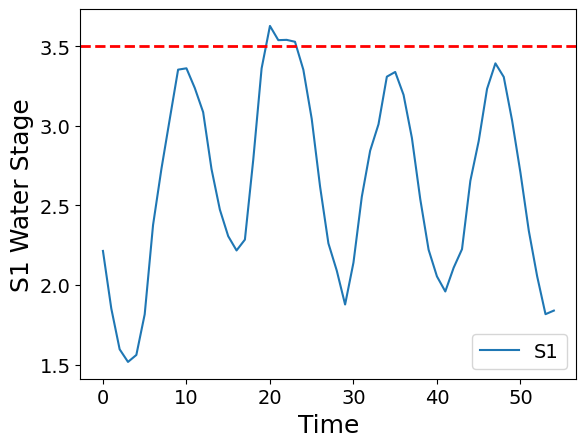

In [127]:
plt.plot(best_perf[:, 0], label='S1')
plt.axhline(y = 3.5, color='r', linestyle='dashed', linewidth=2)
plt.xlabel('Time', fontsize=18)
plt.ylabel('S1 Water Stage', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [122]:
Optimal_gate = pd.DataFrame(best_gate.reshape(duration, -1) )
Optimal_gate.to_csv("GA_results/best_gate_event6.csv", index=False)
Optimal_gate

,0,1,2,3,4,5,6,7,8,9,...,662,663,664,665,666,667,668,669,670,671
0,0.448963,0.289656,0.300493,0.334539,0.202211,0.497357,0.333985,0.913502,0.892476,0.468535,...,0.261612,0.552954,0.143791,0.810991,0.647511,0.109616,0.581474,0.529870,0.784843,0.544467
1,0.296102,0.020020,0.992294,0.334342,0.320261,0.111971,0.629978,0.653036,0.199091,0.584265,...,0.126224,0.053383,0.629760,0.038287,0.727937,0.970881,0.417536,0.185578,0.491905,0.145062
2,0.334183,0.366784,0.860418,0.106539,0.993947,0.257575,0.570609,0.186957,0.111038,0.757262,...,0.541644,0.164716,0.788889,0.605317,0.997285,0.096219,0.187807,0.941433,0.117709,0.308267
3,0.956567,0.535958,0.067073,0.898545,0.608027,0.689851,0.893132,0.915094,0.618307,0.233794,...,0.738898,0.767662,0.054220,0.441164,0.045181,0.749426,0.289559,0.822633,0.434851,0.836074
4,0.691683,0.531530,0.905914,0.983424,0.357616,0.063047,0.186043,0.039312,0.762704,0.532504,...,0.863194,0.081404,0.619058,0.159772,0.018429,0.769814,0.240387,0.044709,0.578423,0.623751
5,0.247339,0.224689,0.482343,0.726825,0.552923,0.464904,0.895719,0.333713,0.215518,0.693626,...,0.573121,0.512059,0.367452,0.336295,0.512378,0.063645,0.154165,0.205589,0.430793,0.759951
6,0.827850,0.029096,0.565826,0.521301,0.617124,0.132593,0.749467,0.775684,0.023705,0.974360,...,0.744122,0.399458,0.361430,0.058651,0.785168,0.539041,0.940716,0.591684,0.543810,0.391052
7,0.433782,0.010598,0.133105,0.790780,0.767670,0.880403,0.022141,0.169458,0.499609,0.149678,...,0.801043,0.226030,0.827368,0.577978,0.845735,0.541844,0.882430,0.422604,0.843150,0.888570
8,0.740690,0.200678,0.108082,0.728793,0.843189,0.176182,0.713808,0.341620,0.062686,0.079633,...,0.457446,0.588072,0.292403,0.525744,0.785101,0.023547,0.051520,0.099194,0.483992,0.221097
9,0.778421,0.145903,0.862954,0.108003,0.936074,0.889999,0.713872,0.127089,0.350020,0.766400,...,0.587956,0.669005,0.389149,0.422497,0.519841,0.687075,0.162708,0.234364,0.476633,0.380145


In [123]:
Optimal_case = pd.DataFrame(best_perf)
Optimal_case.to_csv("GA_results/best_performance_event6.csv", index=False)
Optimal_case

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,2.214092,2.249249,2.282335,2.359124,1.905556,2.005105,2.059593,2.064582,1.674369,1.536561,...,3.776646,3.978291,3.840086,3.823187,3.853287,4.109670,3.594180,3.742476,3.558242,3.876890
1,1.852324,1.950223,1.950959,2.135741,1.716482,1.683293,1.841842,1.958877,1.601524,1.677554,...,3.720830,3.892164,3.602110,3.638046,3.580572,3.807636,3.419111,3.558838,3.501557,3.763286
2,1.596307,1.507607,1.743907,1.900274,1.505461,1.590704,1.642544,1.721195,1.529891,1.584858,...,3.504660,3.669604,3.455241,3.662076,3.403620,3.655302,3.093156,3.137872,3.122233,3.449337
3,1.517052,1.522142,1.704155,1.796883,1.648647,1.820107,1.792479,1.878625,2.020868,2.101631,...,3.379056,3.526071,3.062232,3.000791,3.082308,3.306642,2.714992,2.817372,2.842219,3.121783
4,1.560821,1.806252,1.661014,1.767481,1.912703,1.828714,1.946023,2.033377,2.469927,2.429411,...,3.035377,3.144454,2.712994,2.816979,2.824733,2.990778,2.228168,2.550236,2.405303,2.586313
5,1.816035,1.681405,1.812157,1.949014,2.378527,2.210629,2.314976,2.488030,2.843767,2.806170,...,2.639878,2.756509,2.369877,2.561800,2.530216,2.633286,2.066388,2.336981,2.170520,2.340225
6,2.376612,2.458760,2.366107,2.527361,2.775220,2.710361,2.709696,2.840991,3.158836,3.123236,...,2.413338,2.447753,2.157470,2.386918,2.315570,2.410237,2.048854,2.235720,2.244591,2.387862
7,2.728476,2.733651,2.630147,2.770801,3.108389,3.122435,2.978394,3.126628,3.352167,3.257517,...,2.310211,2.331716,2.121550,2.511427,2.319876,2.369959,2.338261,2.540941,2.459419,2.639519
8,3.041989,3.001505,2.967874,3.192900,3.304556,3.213965,3.141704,3.394349,3.443635,3.500747,...,2.169959,2.177065,2.289088,2.463992,2.455966,2.527652,2.692794,2.749996,2.774831,2.981197
9,3.352603,3.358764,3.197388,3.404256,3.369313,3.316344,3.165564,3.413133,3.313832,3.300812,...,2.347195,2.385280,2.783407,2.792160,2.845192,2.940414,3.076934,3.107188,3.111478,3.304777


In [124]:
upper_threshold = 3.5
lower_threshold = 0

Optimal_case_reshape = Optimal_case.to_numpy().reshape((-1, 24, 4))

flood_threshold(Optimal_case_reshape, upper_threshold)
drought_threshold(Optimal_case_reshape, lower_threshold)

time steps: 657, areas: 130.62833976745605
time steps: 0, areas: 0


In [125]:
upper_threshold = 3.5
lower_threshold = 0

In [126]:
true_ws = saved_model.predict([test_cov[start_idx:end_idx], test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
true_ws = ws_scaler.inverse_transform(true_ws)

true_ws = true_ws.reshape((-1, 24, 4))
flood_threshold(true_ws, upper_threshold)
drought_threshold(true_ws, lower_threshold)

2/2 [==============================] - 0s 4ms/step
time steps: 713, areas: 146.81747794151306
time steps: 0, areas: 0
